# Value At Risk Methods:
1. Historical Method
2. Variance-Covariance Method
3. Monte Carlo Simulation Method

Fetching data from Yahoo Finance...
[*********************100%***********************]  5 of 5 completed

--- Historical VaR ---
Historical VaR (90% confidence): $469,760.91
Historical VaR (95% confidence): $531,090.56
Historical VaR (99% confidence): $887,703.30


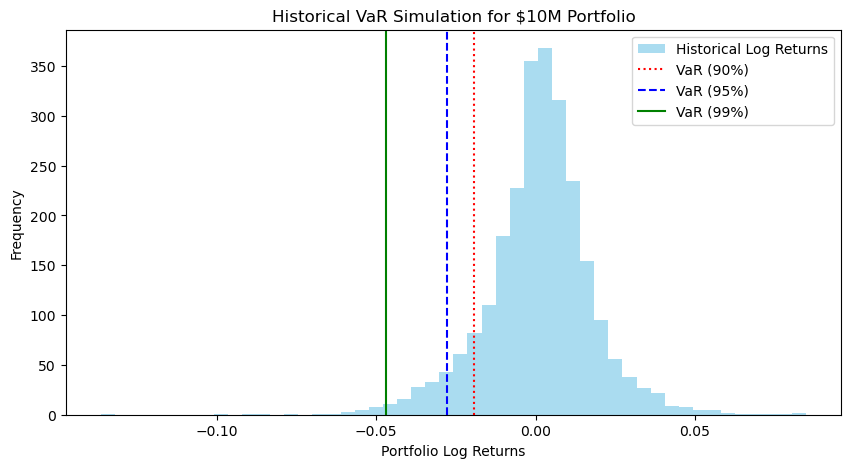


--- Variance-Covariance VaR ---
Variance-Covariance VaR (90% confidence): $219,721.12
Variance-Covariance VaR (95% confidence): $282,009.01
Variance-Covariance VaR (99% confidence): $398,850.72


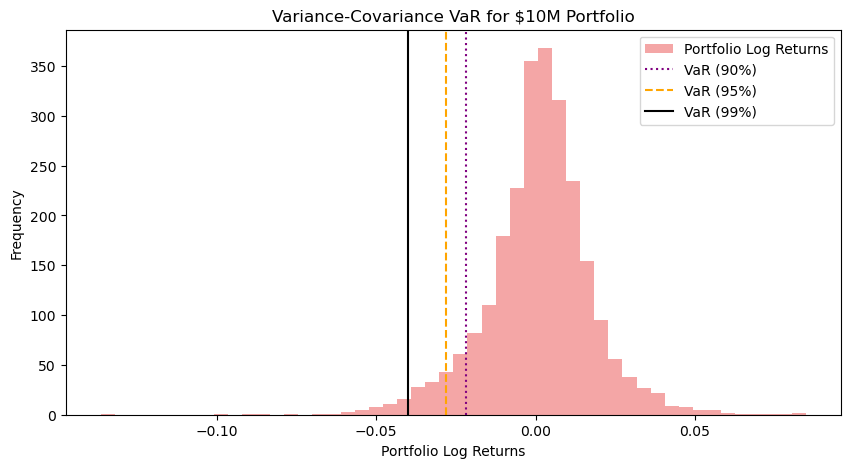


--- Monte Carlo VaR ---
Monte Carlo VaR (90% confidence): $3,477,782.50
Monte Carlo VaR (95% confidence): $4,463,685.52
Monte Carlo VaR (99% confidence): $6,313,075.61


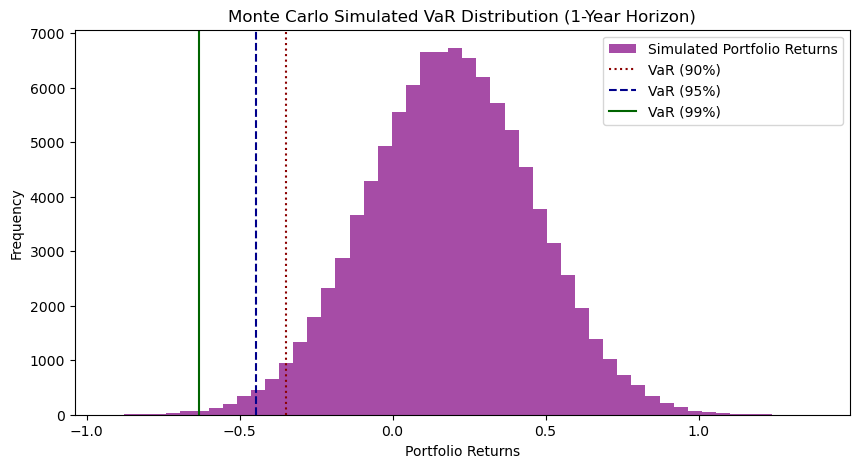

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

class VaRModel:
    def __init__(self, tickers, start_date, end_date, portfolio_value=10_000_000, weights=None):
        """
        Initialize the VaR Model with stock data and portfolio settings.
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.portfolio_value = portfolio_value
        self.data = self._fetch_data()
        self.log_returns = np.log(self.data / self.data.shift(1)).dropna()

        # Assign equal weights if not provided
        self.weights = np.array([1 / len(tickers)] * len(tickers)) if weights is None else np.array(weights)

        # Compute portfolio log returns
        self.portfolio_log_returns = self.log_returns.dot(self.weights)

    def _fetch_data(self):
        """
        Fetch stock data from Yahoo Finance.
        """
        print("Fetching data from Yahoo Finance...")
        return yf.download(self.tickers, start=self.start_date, end=self.end_date)["Adj Close"]

    def historical_var(self, confidence_levels=[0.90, 0.95, 0.99]):
        """
        Compute Historical VaR using sorted log returns.
        """
        VaR_historical = {}
        days_in_year = 252  # Trading days

        sorted_returns = sorted(self.portfolio_log_returns)

        for confidence in confidence_levels:
            loss_position = math.ceil((1 - confidence) * days_in_year)
            VaR_historical[confidence] = -sorted_returns[loss_position - 1] * self.portfolio_value  # Convert to dollar loss

        return VaR_historical

    def variance_covariance_var(self, confidence_levels=[0.90, 0.95, 0.99]):
        """
        Compute Variance-Covariance VaR assuming a normal distribution.
        """
        mu = self.portfolio_log_returns.mean()
        sigma = self.portfolio_log_returns.std()
        VaR_varcov = {}

        for confidence in confidence_levels:
            z_score = norm.ppf(1 - confidence)
            VaR_varcov[confidence] = -z_score * sigma * self.portfolio_value  # Convert to dollar loss

        return VaR_varcov

    def monte_carlo_var(self, simulations=100_000, T=252, confidence_levels=[0.90, 0.95, 0.99]):
        """
        Compute Monte Carlo VaR using Cholesky decomposition and Geometric Brownian Motion (GBM).
        """
        mu = self.log_returns.mean().values
        sigma = self.log_returns.std().values
        corr_matrix = self.log_returns.corr().values

        L = np.linalg.cholesky(corr_matrix)  # Cholesky decomposition

        portfolio_returns = []

        for sim in range(simulations):
            uncorrelated_randoms = np.random.normal(0, 1, (len(self.tickers),))
            correlated_randoms = L @ uncorrelated_randoms

            final_prices = self.data.iloc[-1].values * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * correlated_randoms)
            portfolio_return = np.dot(self.weights, np.log(final_prices / self.data.iloc[-1].values))
            portfolio_returns.append(portfolio_return)

        portfolio_returns = np.array(portfolio_returns)
        portfolio_sigma = np.std(portfolio_returns)

        VaR_monte_carlo = {}
        for confidence in confidence_levels:
            z_score = norm.ppf(1 - confidence)
            VaR_monte_carlo[confidence] = -z_score * portfolio_sigma * self.portfolio_value

        return VaR_monte_carlo, portfolio_returns

    def plot_historical_var(self, VaR_values):
        """
        Plot Historical VaR distribution with updated line styles.
        """
        plt.figure(figsize=(10, 5))
        plt.hist(self.portfolio_log_returns, bins=50, alpha=0.7, label="Historical Log Returns", color="skyblue")

        line_styles = {0.90: ('red', 'dotted'), 0.95: ('blue', 'dashed'), 0.99: ('green', 'solid')}
        
        for confidence, var in VaR_values.items():
            plt.axvline(np.percentile(self.portfolio_log_returns, (1 - confidence) * 100), 
                        color=line_styles[confidence][0], linestyle=line_styles[confidence][1],
                        label=f"VaR ({int(confidence * 100)}%)")

        plt.legend()
        plt.title("Historical VaR Simulation for $10M Portfolio")
        plt.xlabel("Portfolio Log Returns")
        plt.ylabel("Frequency")
        plt.show()

    def plot_variance_covariance_var(self, VaR_values):
        """
        Plot Variance-Covariance VaR distribution with updated line styles.
        """
        plt.figure(figsize=(10, 5))
        plt.hist(self.portfolio_log_returns, bins=50, alpha=0.7, label="Portfolio Log Returns", color="lightcoral")

        line_styles = {0.90: ('purple', 'dotted'), 0.95: ('orange', 'dashed'), 0.99: ('black', 'solid')}
        
        for confidence, var in VaR_values.items():
            plt.axvline(-var / self.portfolio_value, color=line_styles[confidence][0], linestyle=line_styles[confidence][1],
                        label=f"VaR ({int(confidence * 100)}%)")

        plt.legend()
        plt.title("Variance-Covariance VaR for $10M Portfolio")
        plt.xlabel("Portfolio Log Returns")
        plt.ylabel("Frequency")
        plt.show()

    def plot_monte_carlo_var(self, VaR_values, portfolio_returns):
        """
        Plot Monte Carlo VaR distribution with updated line styles.
        """
        plt.figure(figsize=(10, 5))
        plt.hist(portfolio_returns, bins=50, alpha=0.7, label="Simulated Portfolio Returns", color="purple")

        line_styles = {0.90: ('darkred', 'dotted'), 0.95: ('darkblue', 'dashed'), 0.99: ('darkgreen', 'solid')}
        
        for confidence, var in VaR_values.items():
            plt.axvline(-var / self.portfolio_value, color=line_styles[confidence][0], linestyle=line_styles[confidence][1],
                        label=f"VaR ({int(confidence * 100)}%)")

        plt.legend()
        plt.title("Monte Carlo Simulated VaR Distribution (1-Year Horizon)")
        plt.xlabel("Portfolio Returns")
        plt.ylabel("Frequency")
        plt.show()

    def run_all_var_methods(self):
        """
        Run and display results for all VaR methods with plots.
        """
        print("\n--- Historical VaR ---")
        hist_var = self.historical_var()
        for conf, value in hist_var.items():
            print(f"Historical VaR ({conf*100:.0f}% confidence): ${value:,.2f}")
        self.plot_historical_var(hist_var)

        print("\n--- Variance-Covariance VaR ---")
        varcov_var = self.variance_covariance_var()
        for conf, value in varcov_var.items():
            print(f"Variance-Covariance VaR ({conf*100:.0f}% confidence): ${value:,.2f}")
        self.plot_variance_covariance_var(varcov_var)

        print("\n--- Monte Carlo VaR ---")
        monte_carlo_var, portfolio_returns = self.monte_carlo_var()
        for conf, value in monte_carlo_var.items():
            print(f"Monte Carlo VaR ({conf*100:.0f}% confidence): ${value:,.2f}")
        self.plot_monte_carlo_var(monte_carlo_var, portfolio_returns)


# Initialize VaR Model
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
start_date = "2015-01-01"
end_date = "2025-01-01"
portfolio_value = 10_000_000

var_model = VaRModel(tickers, start_date, end_date, portfolio_value)

# Run all VaR calculations with graphs
var_model.run_all_var_methods()
